# Braitenberg Vehicle

This agent moves towards green and yellow goals and away from red goals and lava. It can only do that when it sees them in its current field of view. You could easily extend it to make more complex behavioural patterns, like going towards walls, too.

In [1]:
from animalai.envs.actions import AAIActions, AAIAction
# from animalai.envs.cameraparser import CameraParser
# from animalai.envs.cameraparser import CameraObjects
from animalai.envs.environment import AnimalAIEnvironment
from mlagents_envs.envs.unity_gym_env import UnityToGymWrapper
import random
import pandas as pd
import numpy as np

## Parameters

In [2]:
aai_seed = 127 # set the seed for the random number generator, and then vary this to make a population of agents

STEP_LENGTH = 15 # how many steps to take before taking a random action, vary this to make a population of agents
NUM_EPISODES = 38 # add number of episodes for testing

agent_inference = True

agent_name = "cameraBraitenbergVehicle"

## Paths

In [3]:
configuration_file = r""
env_path = r""
log_folder_path = r""

In [4]:
# Braitenberg vehicle design by M. D. Crosby.
# Adapted by K. Voudouris where noted.
# Further adapted by J. Liu where noted.

class Braitenberg():
    """Implements a simple Braitenberg vehicle agent that heads towards food"""
    def __init__(self, step_length):
        self.actions = AAIActions()
        self.prev_action = self.actions.NOOP
        self.GOODGOAL = np.array([0.7411765, 0.8784314, 0.5411765], dtype=np.float32)
        self.GOODGOALMULTI = np.array([0.9607843,  0.8666667,  0.40784314], dtype=np.float32)
        self.forwards_counter = 0
        self.forwards_active = False

    def get_action_camera(self, obs, step_length) -> AAIAction:
        """Returns the action to take given the current visual observation"""
        """Agent orientates towards good goal"""
        newAction = self.actions.NOOP
        if self.ahead(obs, self.GOODGOAL):
            newAction = self.actions.FORWARDS
        elif self.left(obs, self.GOODGOAL):
            newAction = self.actions.FORWARDSLEFT
        elif self.right(obs, self.GOODGOAL):
            newAction = self.actions.FORWARDSRIGHT
        elif self.ahead(obs, self.GOODGOALMULTI):
            newAction = self.actions.FORWARDS
        elif self.left(obs, self.GOODGOALMULTI):
            newAction = self.actions.FORWARDSLEFT
        elif self.right(obs, self.GOODGOALMULTI):
            newAction = self.actions.FORWARDSRIGHT
        else:
            #if self.prev_action == self.actions.NOOP or self.prev_action == self.actions.BACKWARDS:
            """
            KV Addition: if the agent cannot see a goodgoal, multigoal, or badgoal, then pick a random action
            The agent has a 'step_length'/'step_length+1' probability of taking the action it just took, or of taking a new action
            """
            take_steps = random.randint(0, step_length) 
            if take_steps != 0:
                newAction = self.prev_action
            else:
                rand_action = random.randint(0,8) # pick one of 9 actions randomly
                if (rand_action == 0):
                    newAction = self.actions.NOOP
                elif (rand_action == 1):
                    newAction = self.actions.FORWARDS
                elif (rand_action == 2): 
                    newAction = self.actions.FORWARDSRIGHT
                elif (rand_action == 3):
                    newAction = self.actions.RIGHT
                elif (rand_action == 4):
                    newAction = self.actions.BACKWARDSRIGHT
                elif (rand_action == 5):
                    newAction = self.actions.BACKWARDS
                elif (rand_action == 6):
                    newAction = self.actions.BACKWARDSLEFT
                elif (rand_action == 7):
                    newAction = self.actions.LEFT
                else:
                    newAction = self.actions.FORWARDSLEFT
        """
        JL Addition: If the agent has been moving forwards towards a good goal for 3 timesteps, take 80 steps forwards but doing NOOP every third to prevent overshoot on 12 Cup (Grid) tasks
        """
        if (self.ahead(obs, self.GOODGOAL) or self.ahead(obs, self.GOODGOALMULTI)) and newAction == self.actions.FORWARDS:
            self.forwards_counter += 1
        
        if self.forwards_counter == 3:
            self.forwards_active = True

        if self.forwards_active == True:
            if self.forwards_counter % 3 == 0:
                newAction = self.actions.NOOP
            else:
                newAction = self.actions.FORWARDS
            self.forwards_counter += 1
        
        if self.forwards_counter >= 80:
            self.forwards_counter = 0
            self.forwards_active = False

        self.prev_action = newAction
        return newAction


    def ahead(self, obs, object):
        """Returns true if the input object is ahead of the agent"""
        middle = obs[:, obs.shape[1]//2-1:obs.shape[1]//2+1, :]
        if np.any(np.all(middle == object, axis=-1)):
            print("found good goal middle!")
            return True
        else:
            return False

    def left(self, obs, object):
        """Returns true if the input object is left of the agent"""
        left_half = obs[:, :obs.shape[1]//2, :]
        if np.any(np.all(left_half == object, axis=-1)):
            print("found goal left!")
            return True
        else:
            return False


    def right(self, obs, object):
        """Returns true if the input object is right of the agent"""
        right_half = obs[:, obs.shape[1]//2:, :]
        if np.any(np.all(right_half == object, axis=-1)):
            print("found goal right!")
            return True
        else:
            return False

In [5]:
random.seed(aai_seed) #set seed for random action selection

port = 5005 + random.randint(
    0, 1000
)  # use a random port to avoid problems if a previous version exits slowly

aai_env = AnimalAIEnvironment( 
    inference=agent_inference,
    seed = aai_seed,
    log_folder = log_folder_path,
    worker_id=aai_seed,
    file_name=env_path,
    arenas_configurations=configuration_file,
    base_port=port,
    useCamera=True,
    resolution=128,
    useRayCasts=False,
)
env = UnityToGymWrapper(aai_env, uint8_visual=True, allow_multiple_obs=False, flatten_branched=True)

#obs = env.reset()


braitenbergAgent = Braitenberg(STEP_LENGTH)
behavior = list(aai_env.behavior_specs.keys())[0] # by default should be AnimalAI?team=0

reward_list = []
firststep = True
for _episode in range(NUM_EPISODES): #Run episodes with the Braitenberg-style agent
    if firststep:
        aai_env.step() # Need to make a first step in order to get an observation.
        firstep = False
    dec, term = aai_env.get_steps(behavior)
    done = False
    episodeReward = 0
    while not done:
        camera = aai_env.get_obs_dict(dec.obs)["camera"] # Get the camera data
        action = braitenbergAgent.get_action_camera(camera, STEP_LENGTH)
        aai_env.set_actions(behavior, action.action_tuple)
        aai_env.step()
        dec, term = aai_env.get_steps(behavior)
        if len(dec.reward) > 0:
            episodeReward += dec.reward
        if len(term) > 0: #Episode is over
            episodeReward += term.reward
            print(F"Episode Reward: {episodeReward}")
            reward_list.append(episodeReward)
            done = True
            firststep = True 
aai_env.close()

reward_df = pd.DataFrame(reward_list, columns = ['finalRewards'])

csv_path = log_folder_path + "/" + agent_name + "_Seed_" + str(aai_seed) + "_StepLength_" + str(STEP_LENGTH) + ".csv"
reward_df.to_csv(csv_path, index = False)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

/Users/jason/miniconda/envs/aai3/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Episode Reward: [-1.079]
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found good goal middle!
found goal righ

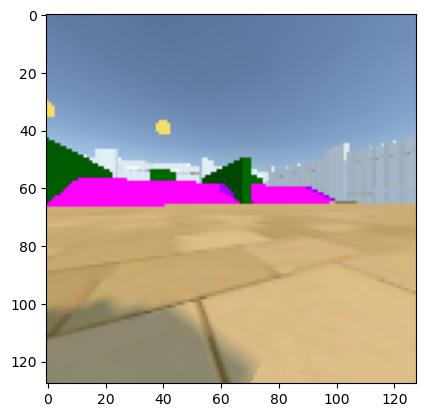

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(camera[:,:,:])

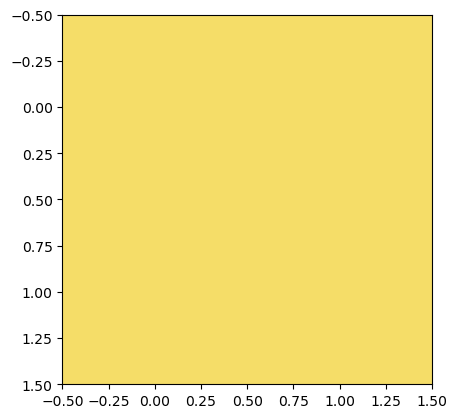

In [ ]:
plt.imshow(camera[40:42,40:42,:])

In [ ]:
print(camera[40:42,40:42,:])

[[[0.9607843  0.8666667  0.40784314]
  [0.9607843  0.8666667  0.40784314]]

 [[0.9607843  0.8666667  0.40784314]
  [0.9607843  0.8666667  0.40784314]]]
